## Import Library & Data Loading

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
import yfinance as yf
import itertools
import matplotlib.dates as mdates
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, BatchNormalization, Dropout, GRU
from tensorflow.keras.optimizers import Adam
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA

In [6]:
data = yf.download('ISAT.JK', start='2018-06-01', end='2025-04-01')
data = data.reset_index()
data.to_csv('indosat_stock_data.csv', index=False)
stock_data = pd.read_csv('indosat_stock_data.csv')
stock_data = stock_data.iloc[1:]

[*********************100%***********************]  1 of 1 completed

## Data Understanding

Tahapan ini berfokus pada mengetahui unsur-unsur dari data yang telah di-load. Beberapa diantaranya yaitu jumlah baris-kolom, tipe data setiap kolom, mengecek statistik deskriptif, identifikasi missing value atau outlier, visualisasi distribusi dan pola pada data, dan lain sebagainya. 

##### Mencari info tipe data setiap kolom & jumlah baris-kolom

In [7]:
stock_data.head()

,Date,Close,High,Low,Open,Volume
1,2018-06-01,740.6533813476562,740.6533813476562,740.6533813476562,740.6533813476562,0
2,2018-06-04,749.6310424804688,756.3642554368802,736.164616567646,740.6534252052536,9891600
3,2018-06-05,772.0750732421875,799.0079246343568,749.6310304153797,749.6310304153797,18685600
4,2018-06-06,758.608642578125,781.0526852579512,758.608642578125,772.0750681860208,9908000
5,2018-06-07,745.1422119140625,767.5862544415945,742.8978076613093,767.5862544415945,7280800


In [8]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 1 to 1679
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    1679 non-null   object
 1   Close   1679 non-null   object
 2   High    1679 non-null   object
 3   Low     1679 non-null   object
 4   Open    1679 non-null   object
 5   Volume  1679 non-null   object
dtypes: object(6)
memory usage: 78.8+ KB


In [9]:
print(f"Jumlah data (baris, kolom): {stock_data.shape}")

Jumlah data (baris, kolom): (1679, 6)


Hasilnya menyatakan bahwa:
- Dataset ini terdiri dari 1679 data dan 6 kolom (Date, Close, High, Low, Open, Volume)
- Semua tipe datanya masih belum sesuai (kolom angka harusnya berbentuk float dan integer)

In [10]:
stock_data['Date'] = pd.to_datetime(stock_data['Date'])

list_cols_to_float = ['Close', 'Open', 'High', 'Low']
stock_data[list_cols_to_float] = stock_data[list_cols_to_float].astype('float64').round(5)

stock_data['Volume'] = stock_data['Volume'].astype('int64')

In [11]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1679 entries, 1 to 1679
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1679 non-null   datetime64[ns]
 1   Close   1679 non-null   float64       
 2   High    1679 non-null   float64       
 3   Low     1679 non-null   float64       
 4   Open    1679 non-null   float64       
 5   Volume  1679 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 78.8 KB


Tindakan pengubahan tipe data harus dilakukan lebih awal untuk memudahkan dalam analisis-analisis berikutnya

##### Mengecek Statistik Deskriptif Kolom

In [12]:
stock_data.describe()

,Date,Close,High,Low,Open,Volume
count,1679,1679.000000,1679.000000,1679.000000,1679.000000,1.679000e+03
mean,2021-10-11 06:02:47.242406144,1400.710805,1430.635271,1373.914968,1403.008933,2.497975e+07
min,2018-06-01 00:00:00,269.328520,298.505770,267.084110,273.817330,0.000000e+00
25%,2020-01-15 12:00:00,646.388430,664.343660,636.288630,647.510640,8.584400e+06
50%,2021-10-07 00:00:00,1430.807740,1464.473730,1400.000000,1431.250000,1.527440e+07
75%,2023-06-30 00:00:00,1893.750000,1925.625000,1875.000000,1893.750000,2.625740e+07
max,2025-03-27 00:00:00,3012.500000,3062.500000,2962.500000,3012.500000,5.864944e+08
std,NaN,760.194685,771.100321,747.710239,761.241170,3.862022e+07


##### Identifikasi missing value, data duplikat, dan outlier

In [13]:
print("Jumlah Missing Value pada setiap kolom: ")
stock_data.isna().sum()

Jumlah Missing Value pada setiap kolom: 


Date      0
Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [14]:
print(f"Jumlah data yang terduplikat: {stock_data.duplicated().sum()}")

Jumlah data yang terduplikat: 0


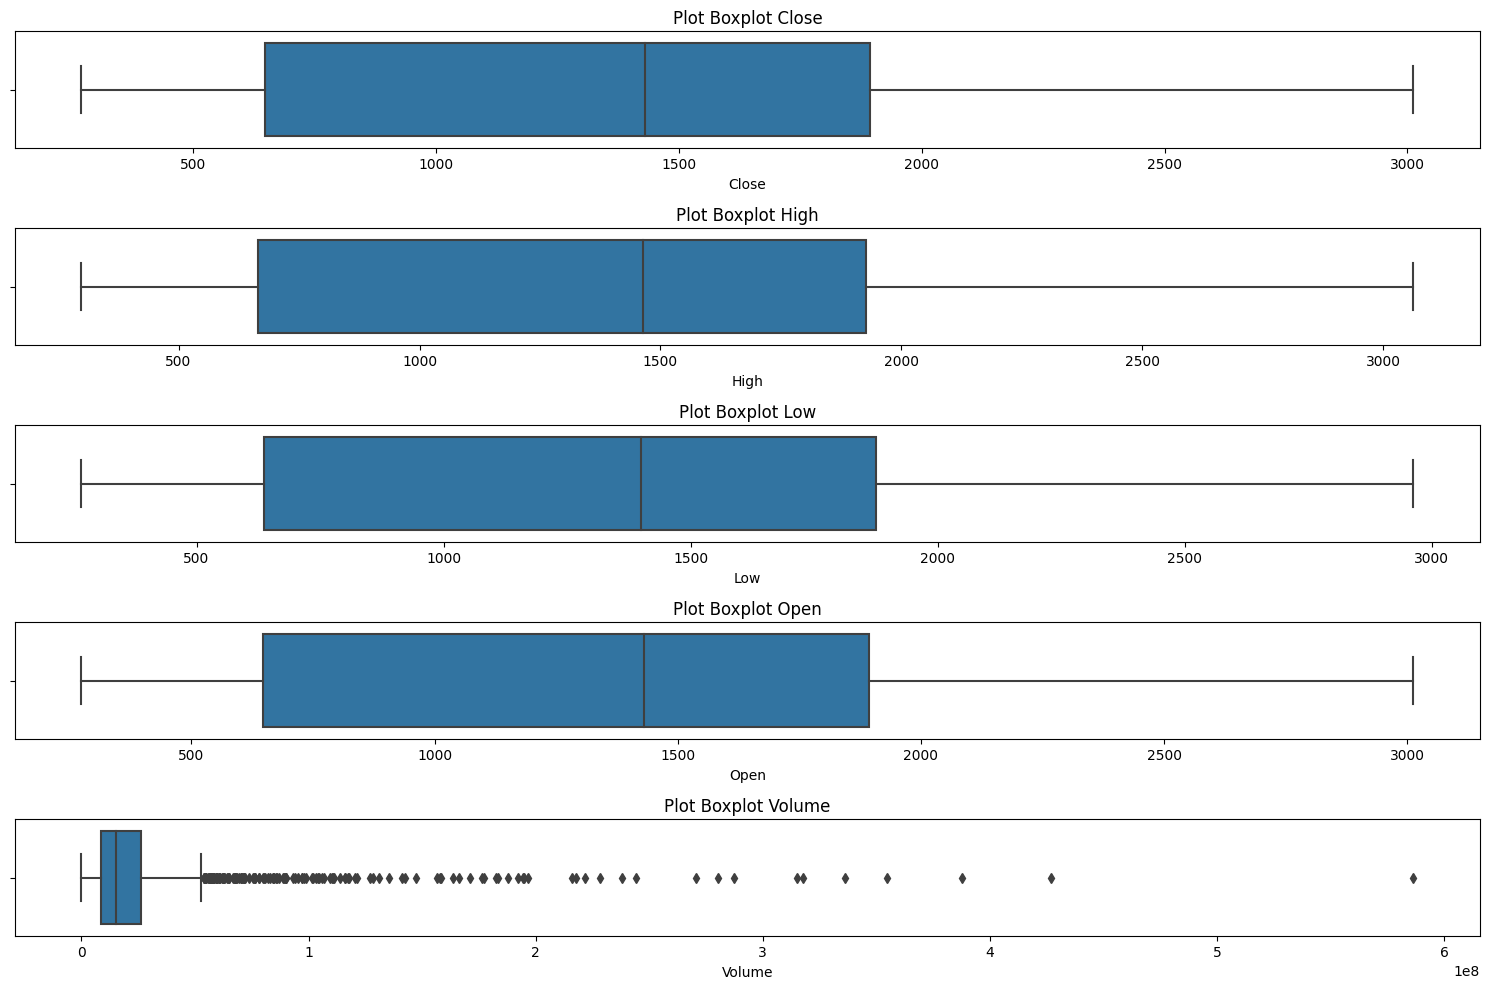

In [15]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']
fig, axes = plt.subplots(len(cols), 1, figsize=(15, 10))

for ax, col in zip(axes, cols):
    sns.boxplot(x=col, data=stock_data, ax=ax)
    ax.set_title(f'Plot Boxplot {col}')

plt.tight_layout()
plt.show()

- Tidak terdapat missing value maupun data yang terduplikat
- Terdapat outlier pada kolom volume (untuk saat ini belum akan ada tindakan lanjutan mengingat data yang terbatas)

##### Visualisasi Distribusi & Pola pada Data

c:\Users\hardi\anaconda3\envs\py310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hardi\anaconda3\envs\py310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hardi\anaconda3\envs\py310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\hardi\anaconda3\envs\py310\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version

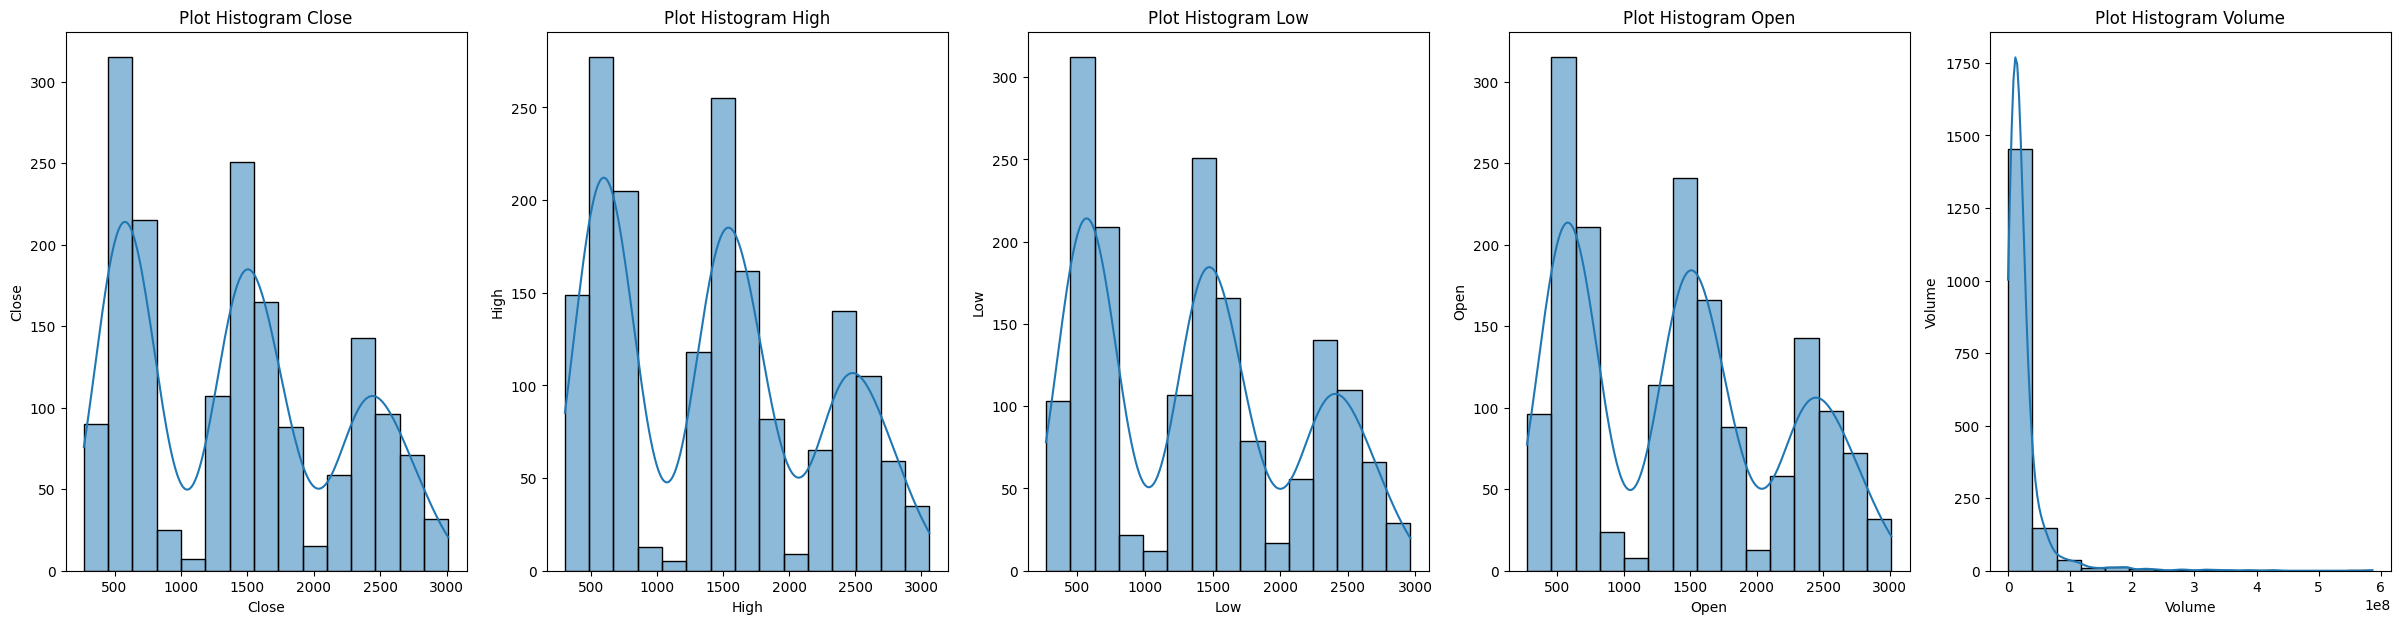

In [16]:
plt.figure(figsize=(30, 7))

for i, col in enumerate(cols):
    plt.subplot(1, len(cols), i + 1)
    sns.histplot(stock_data[col], bins=15, kde=True)
    plt.title(f'Plot Histogram {col}')
    plt.ylabel(col)

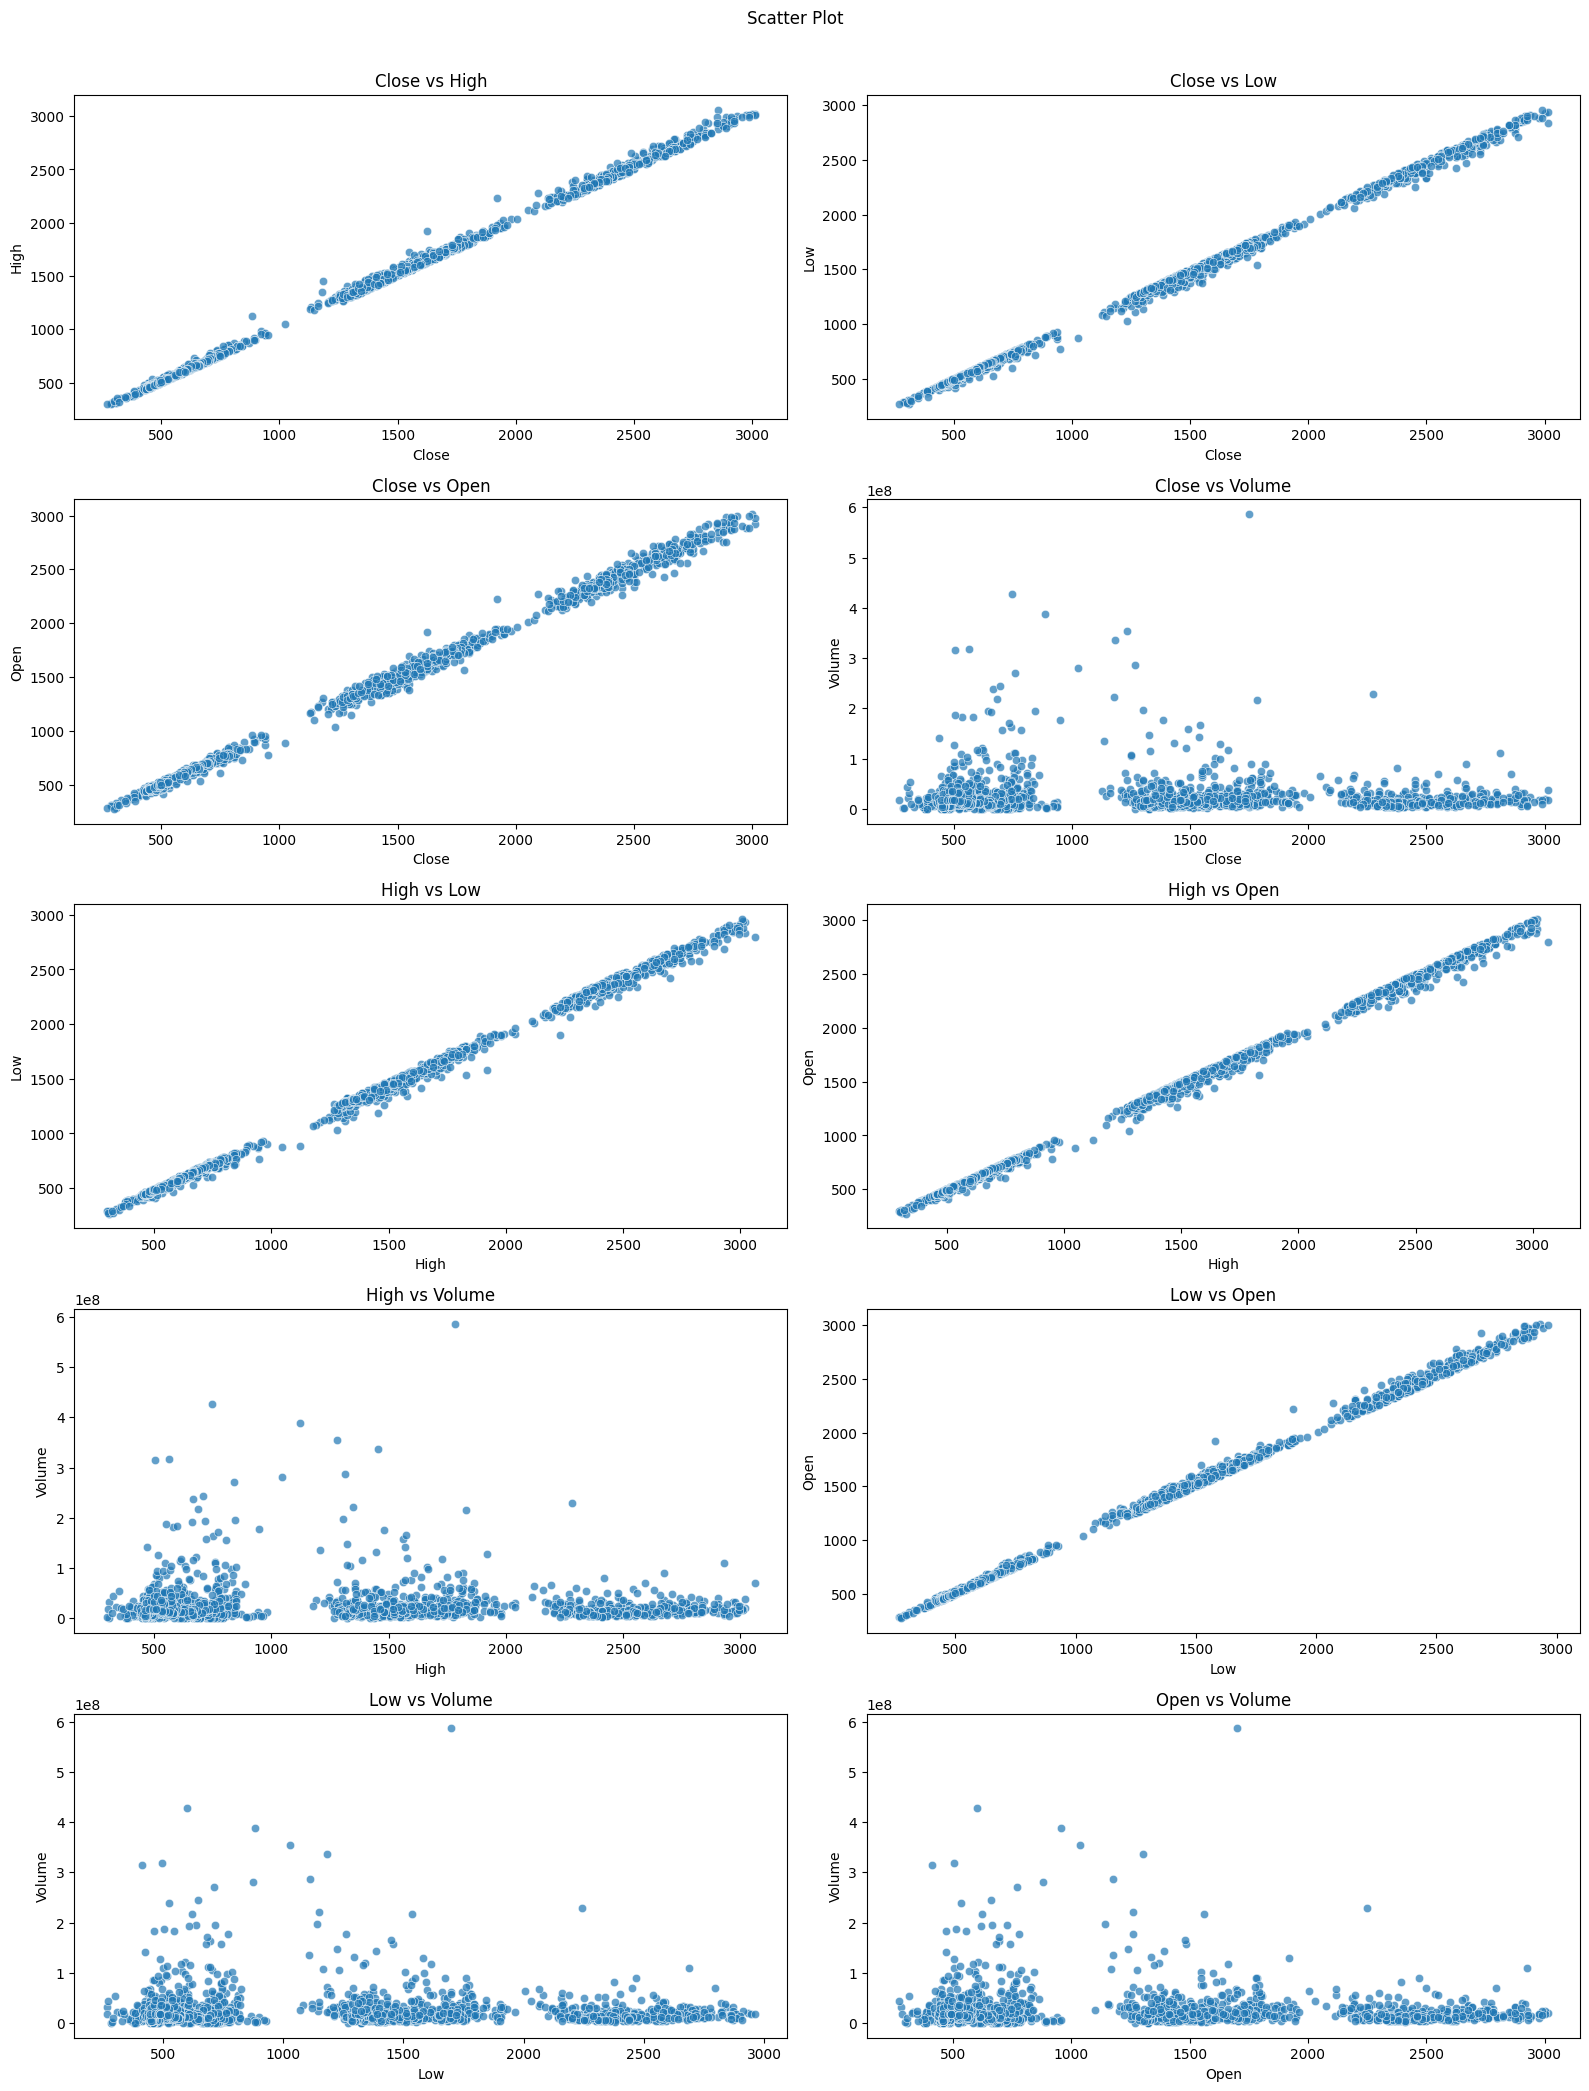

In [17]:
plt.figure(figsize=(16, 24))

combinations = list(itertools.combinations(cols, 2))

for i, (x, y) in enumerate(combinations, 1):
    plt.subplot(len(combinations)//2 + 1, 2, i)
    sns.scatterplot(data=stock_data, x=x, y=y, alpha=0.7)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.title(f'{x} vs {y}')

plt.tight_layout()
plt.suptitle("Scatter Plot", y=1.02)
plt.show()

Hasil analisa distribusi data:
- Distribusi pada kolom fitur Close, Open, High, Low memiliki banyak puncak dan tidak simetris. Distribusi terlihat agak terpisah dalam beberapa interval. Ini bisa mengindikasikan adanya beberapa kelompok atau segmentasi dalam data harga saham tersebut.
- Distribusi volume sangat right-skewed (miring ke kanan), dengan banyak nilai kecil dan beberapa nilai yang sangat besar (outlier).
- Transformasi akan dilakukan pada tahapan berikutnya dalam upaya mengurangi skewness.

Hasil analisa hubungan pola data:
- Terdapat beberapa pasangan kolom data yang memiliki korelasi linear dan positif, yaitu:
    - Close-High | Close-Low | Close-Open
    - High-Low | High-Open
    - Low-Open
- Ini menandakan bahwa 4 kolom (Close, High, Low, Open) saling berkorelasi kuat secara linear
- Untuk hubungan 4 kolom tadi terhadap volume, hasilnya menyatakan bahwa tidak memiliki hubungan linear yang kuat

## Exploratory Data Analysis

Berdasarkan hasil data understanding di bagian sebelumnya, akan dilakukan analisis-analisis untuk mengetahui informasi yang bisa diperoleh dari dataset ini

##### Melihat tren data dari waktu ke waktu

In [18]:
def graph_feature(data):
    pairs = [('Close', 'Open'), ('High', 'Low')]
    for pair in pairs:  
        plt.figure(figsize=(20, 6))  
 
        plt.plot(data['Date'], data[pair[0]], label=pair[0])  
        plt.plot(data['Date'], data[pair[1]], label=pair[1])  

        plt.xlabel('Time Period')
        plt.ylabel('Value')  
        plt.title(f'Time Series Graph {pair[0]} & {pair[1]}')  
        plt.legend()  
        plt.grid(True)  
        plt.tight_layout()
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=12))
        plt.xticks(rotation=45)
        plt.show()

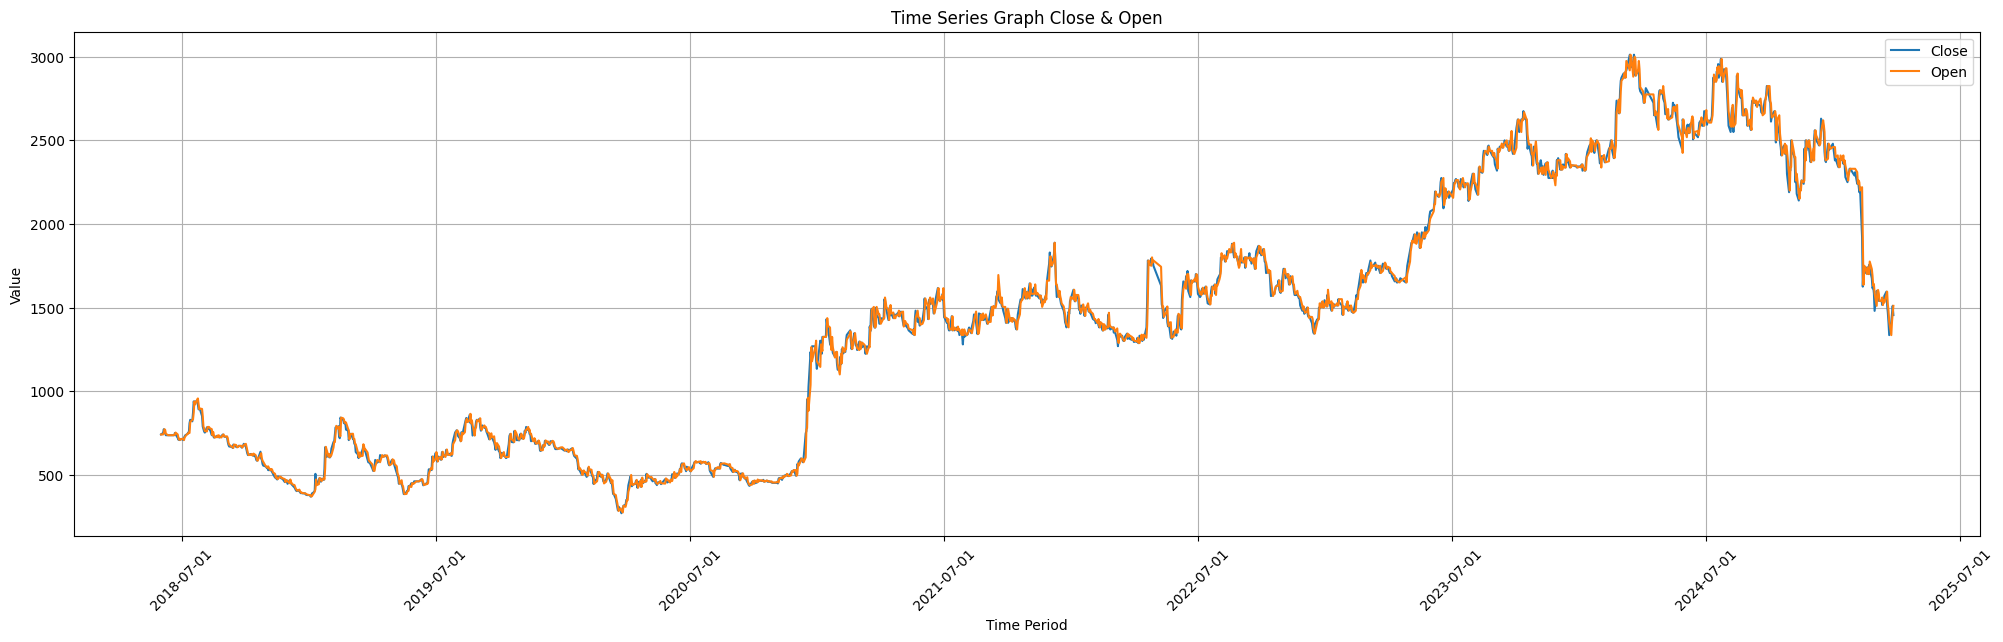

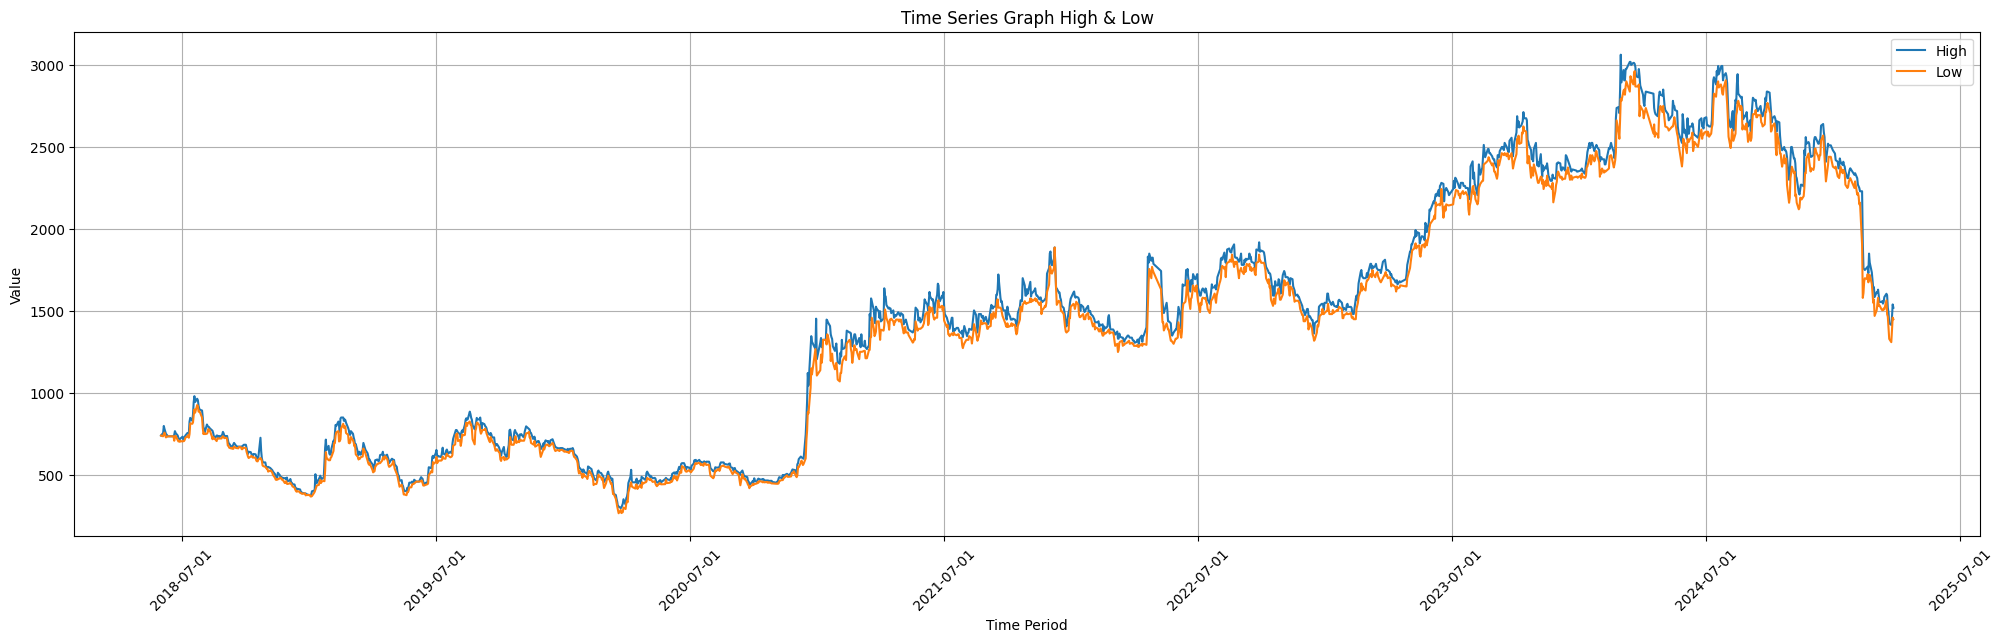

In [19]:
graph_feature(stock_data)

Hasil analisa untuk grafik waktu pada data:
- Nilai saham cenderung mengalami peningkatan harga hingga mengalami puncaknya pada pertengahan tahun 2024.
- Setelah mengalami puncak harga saham, perlahan-lahan nilainya kembali mengalami penurunan hingga tahun 2025 

##### Megecek beberapa hal pada setiap kolom dengan seasonal compose

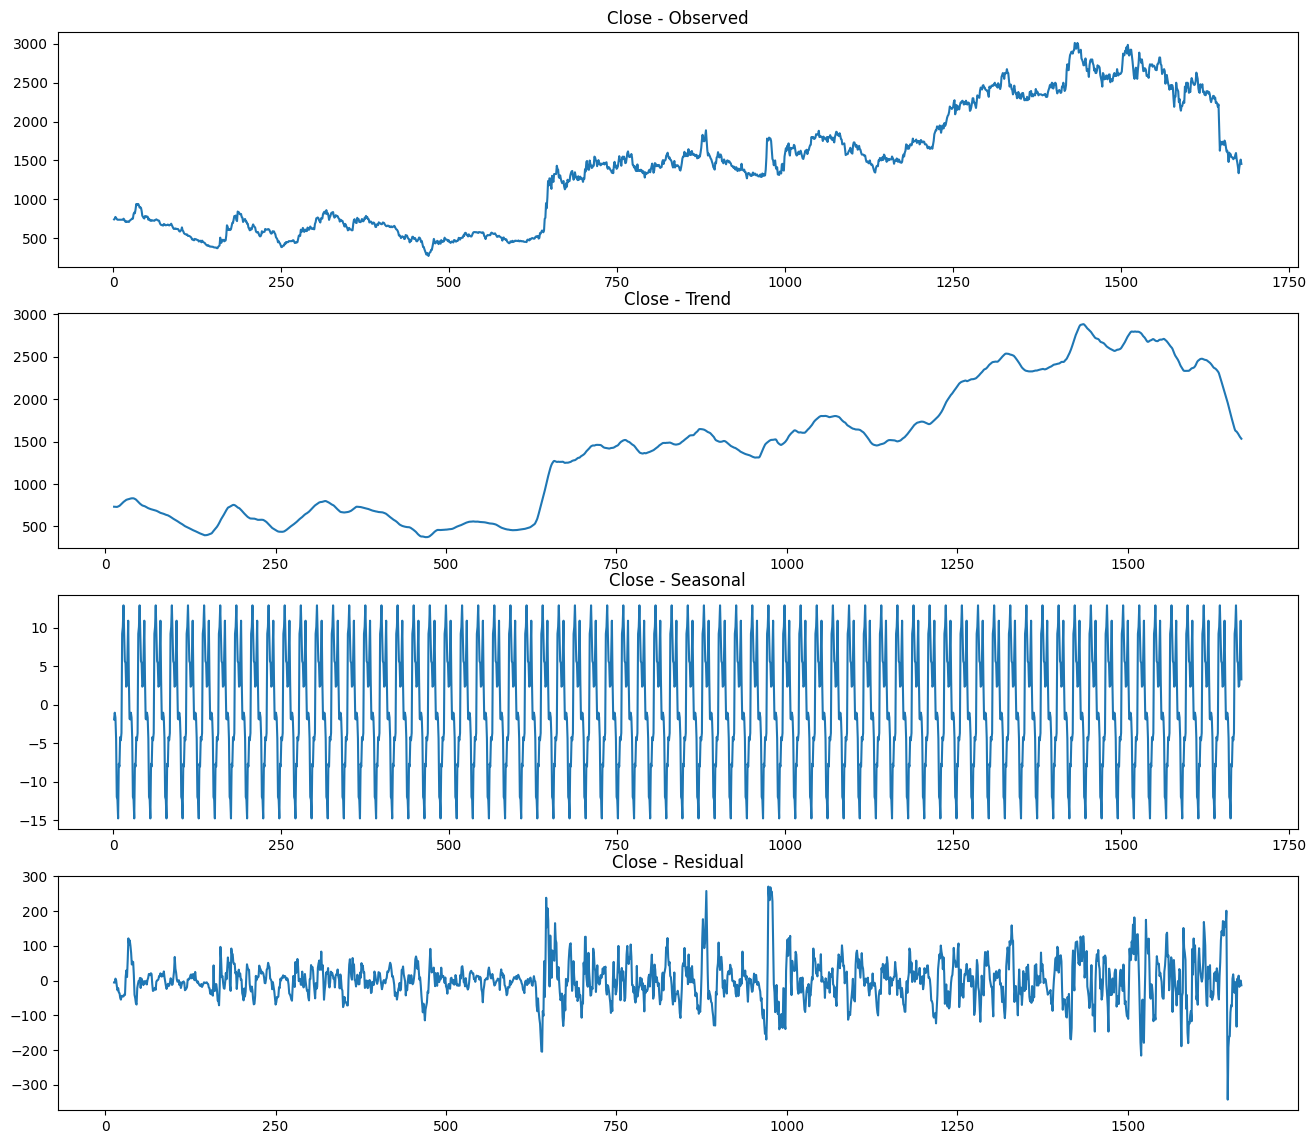

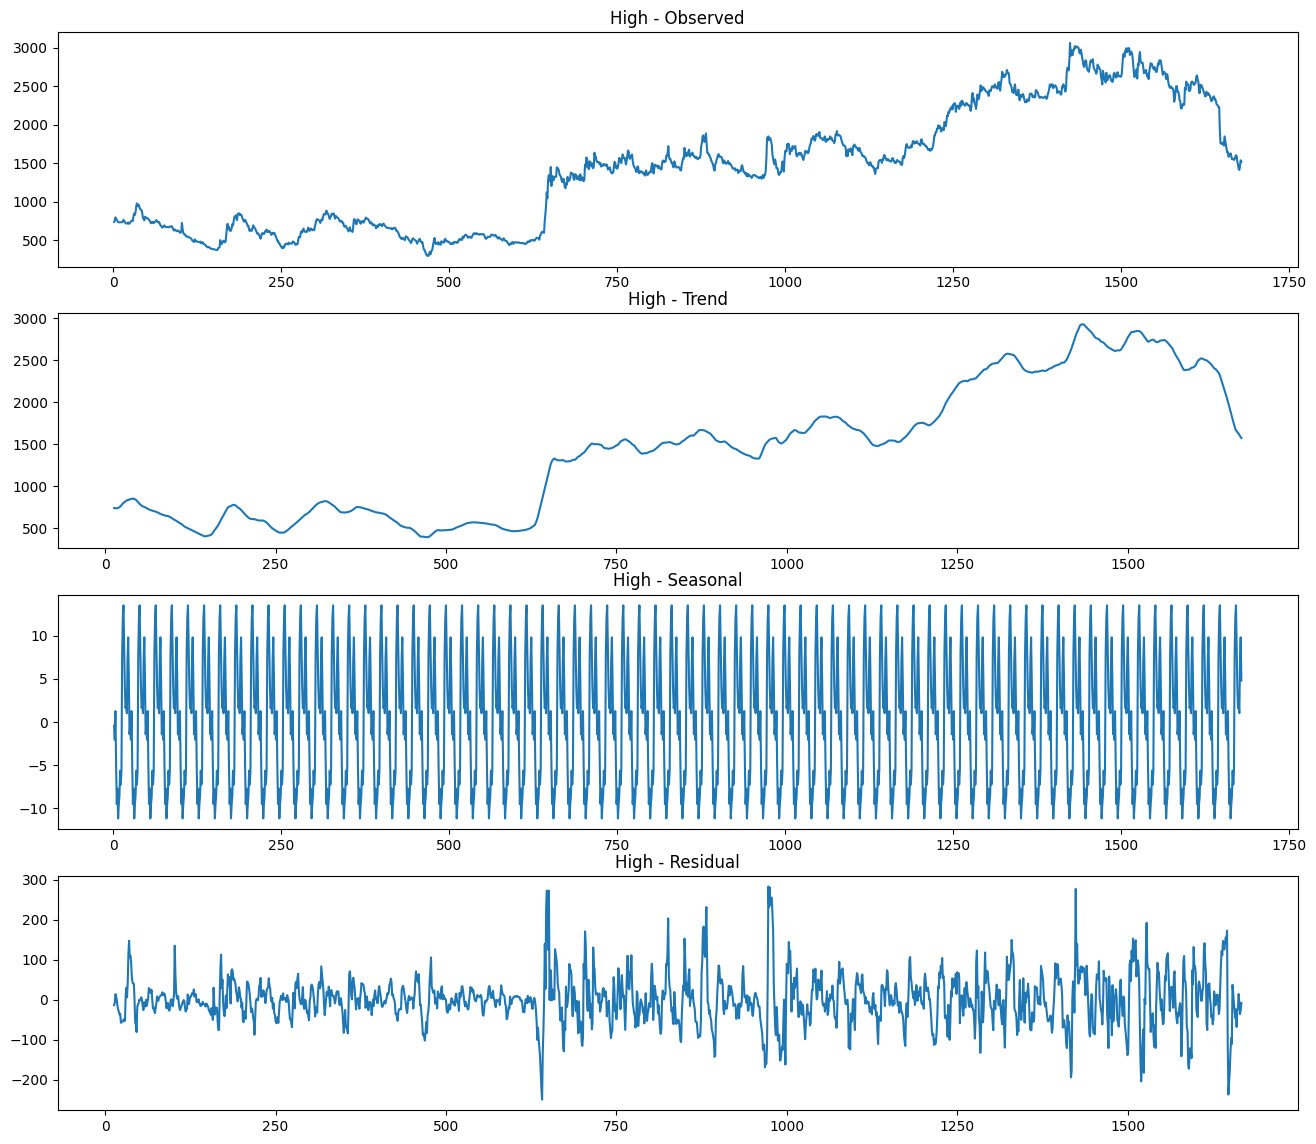

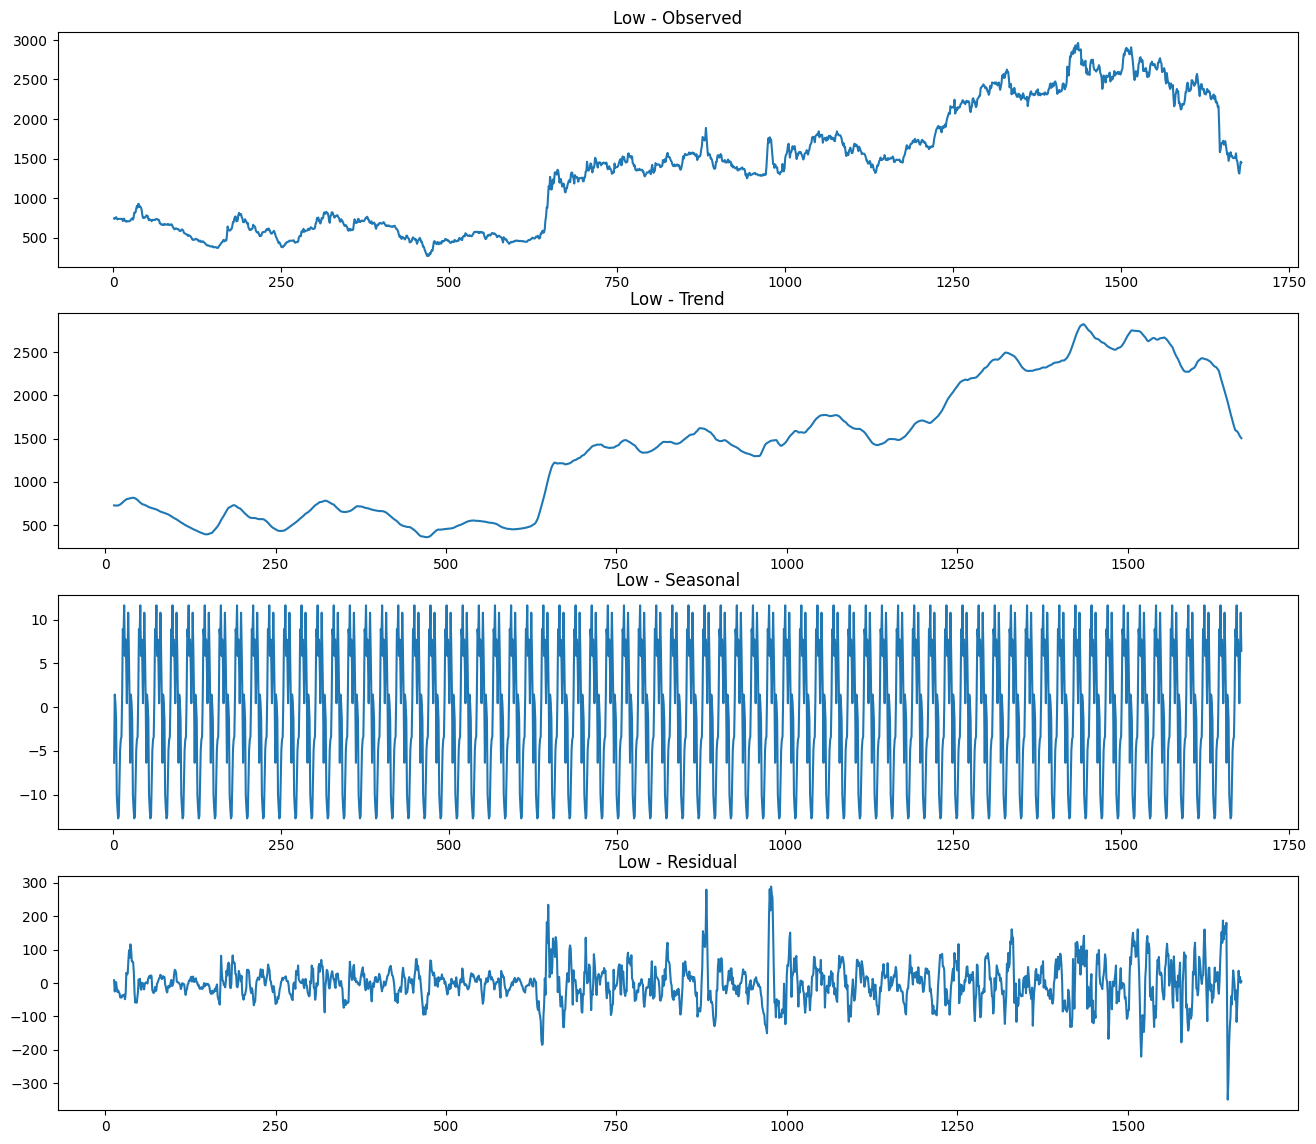

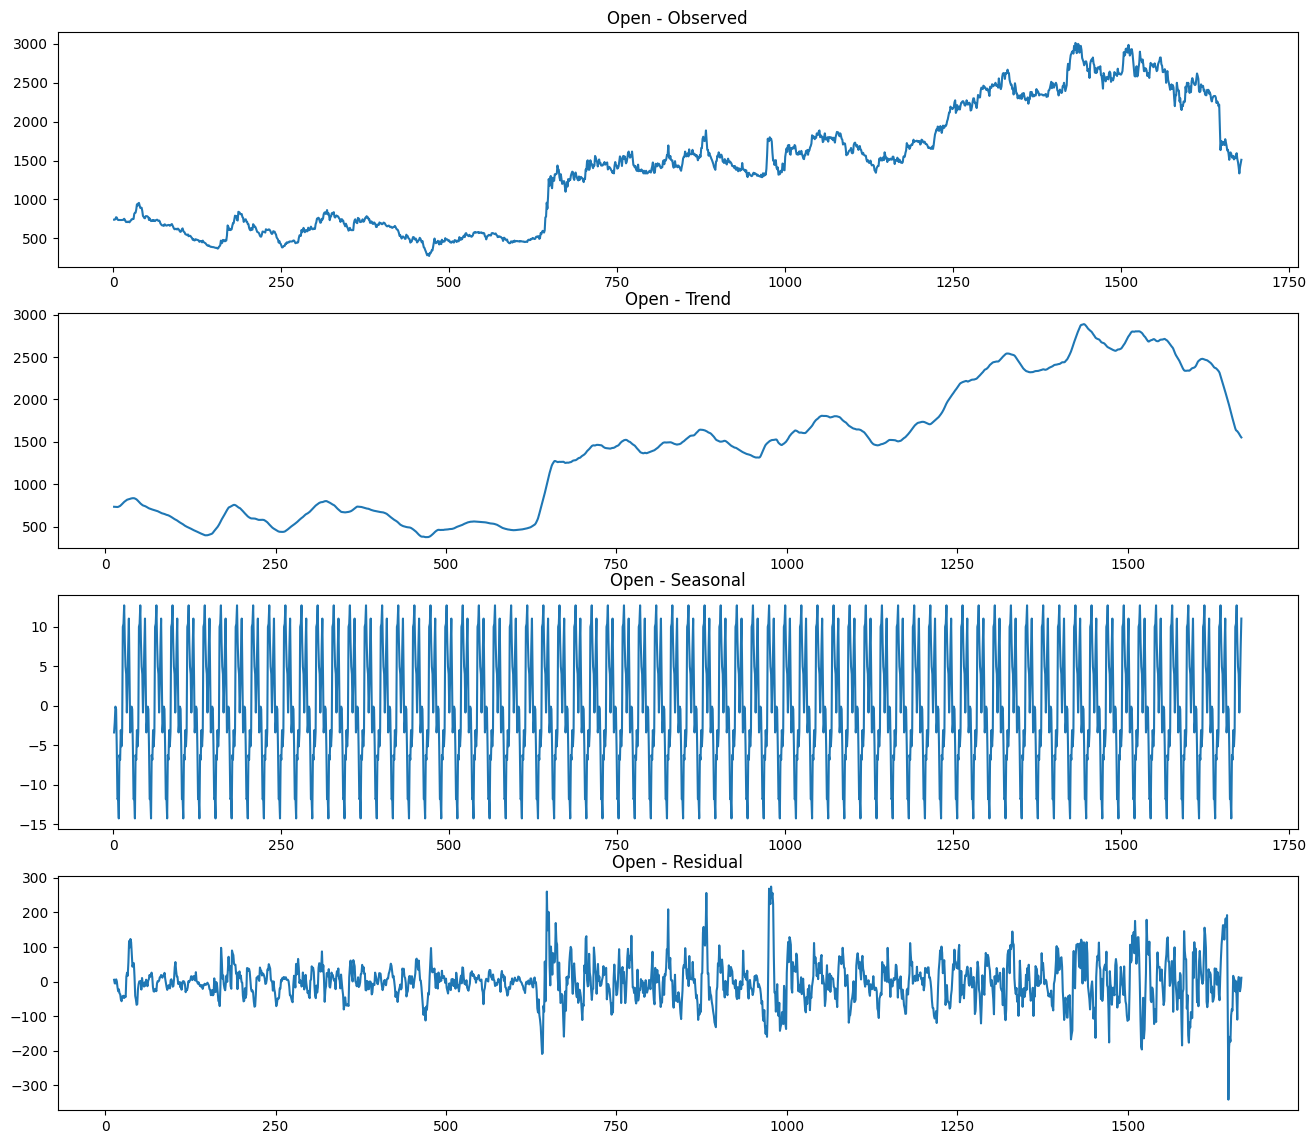

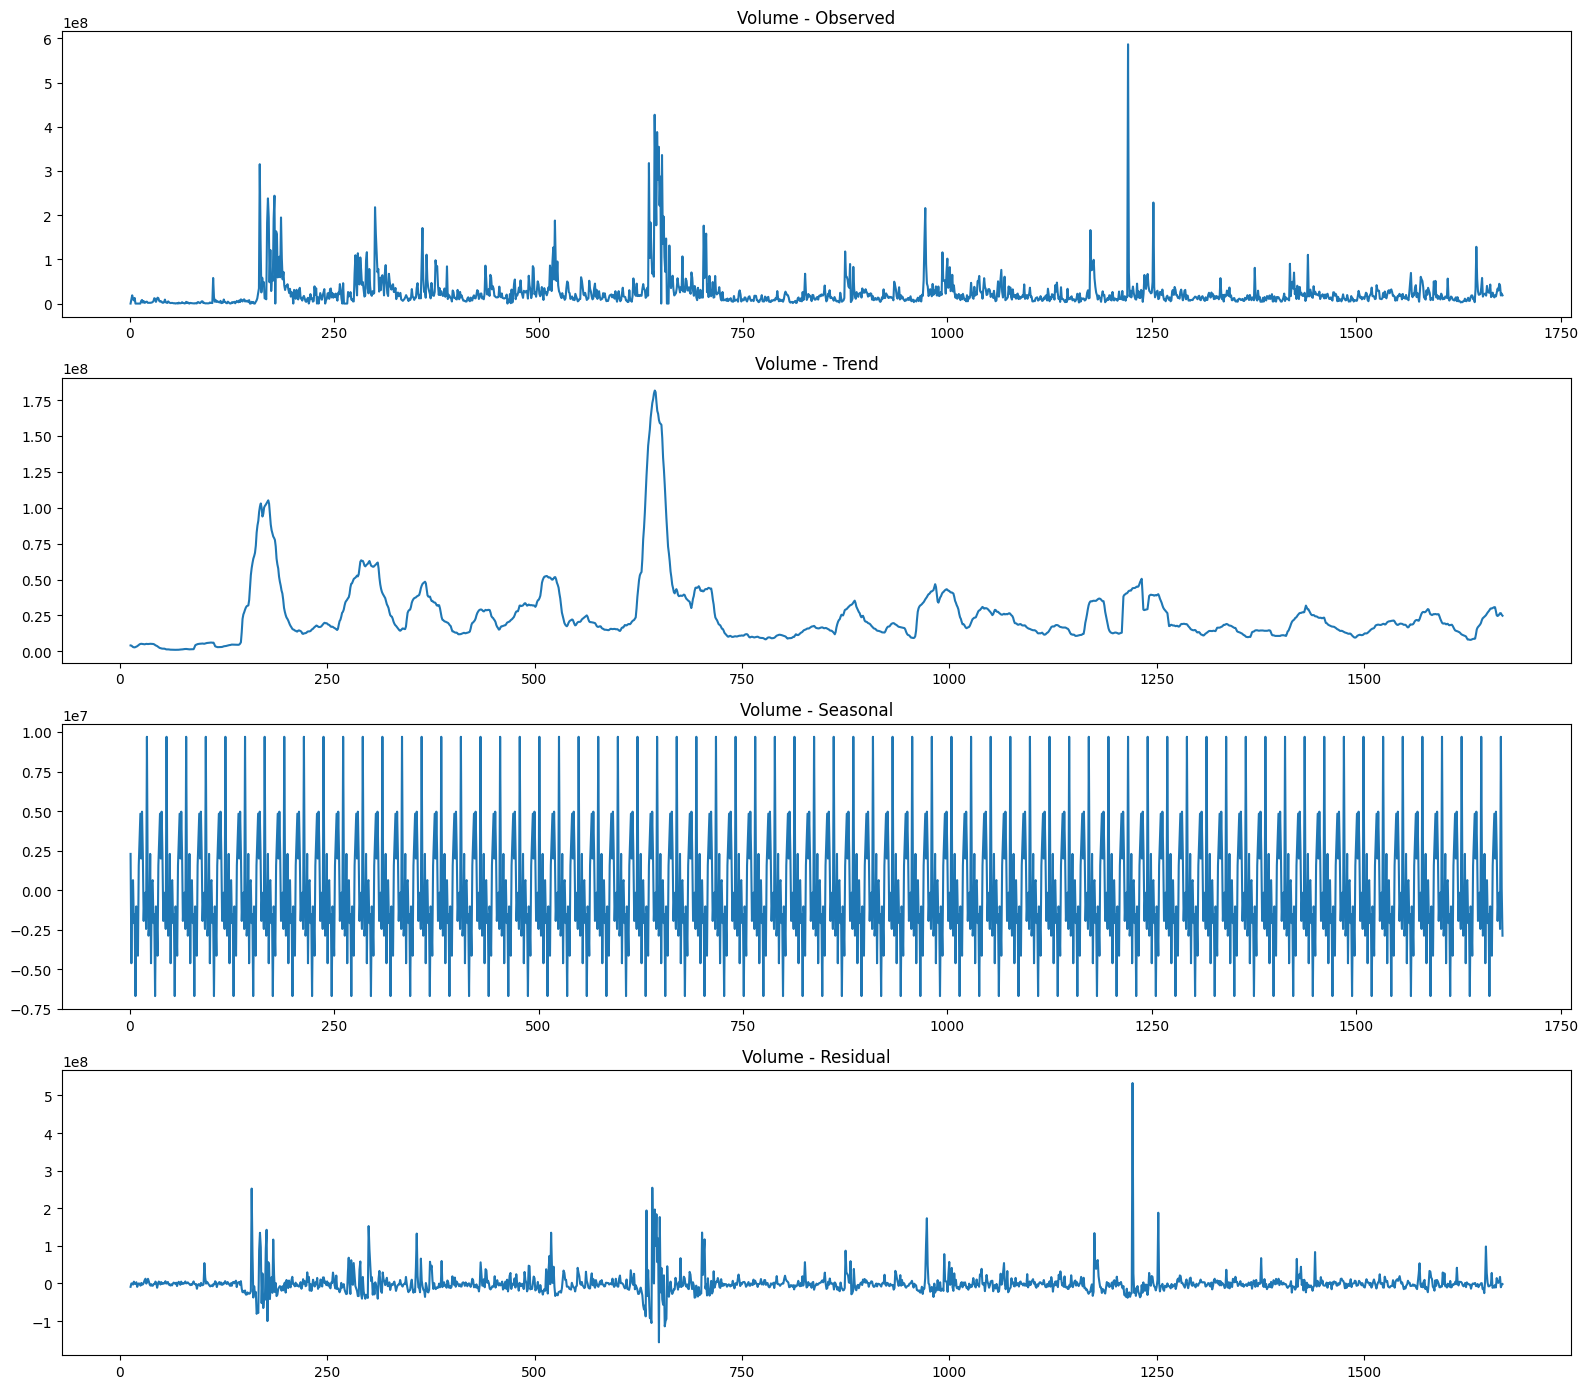

In [20]:
n_cols = len(cols)  

for i, col in enumerate(cols):
    fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(16, 14))

    data = stock_data[col].dropna()
    result = seasonal_decompose(data, model='additive', period=24) 

    ax[0].plot(result.observed)  
    ax[0].set_title(f'{col} - Observed')  
    
    ax[1].plot(result.trend)  
    ax[1].set_title(f'{col} - Trend')
    
    ax[2].plot(result.seasonal)  
    ax[2].set_title(f'{col} - Seasonal')  
    
    ax[3].plot(result.resid)  
    ax[3].set_title(f'{col} - Residual')  

plt.tight_layout()  
plt.show() 

Hasil analisa untuk grafik Open, Close, High, Low:
- Observed : Menunjukkan peningkatan harga. Namun pada bagian akhir dari data, nampak mengalami penurunan   
- Trend : Cenderung mengalami kenaikan bertahap, lalu sedikit mengalami penurunan, kemudian akan kembail mengalami kenaikan
- Seasonal : Polanya menunjukkan siklus yang teratur.
- Residual : Dalam grafik ini, terdapat nilai dengan outlier.

Hasil analisa untuk grafik Volume:
- Observed : Menunjukkan tren stabil, dengan adanya beberapa waktu tertentu yang mengalami kenaikan volume.
- Trend : Cenderung mengalami tren konstan meskipun terdapat beberapa lonjakan pada periode waktu tertentu.
- Seasonal : Polanya menunjukkan siklus yang teratur.
- Residual : Terdapat beberapa nilai yang mengandung outlier.

##### Melihat grafik ACF dan PACF di setiap kolomnya

c:\Users\hardi\anaconda3\envs\py310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


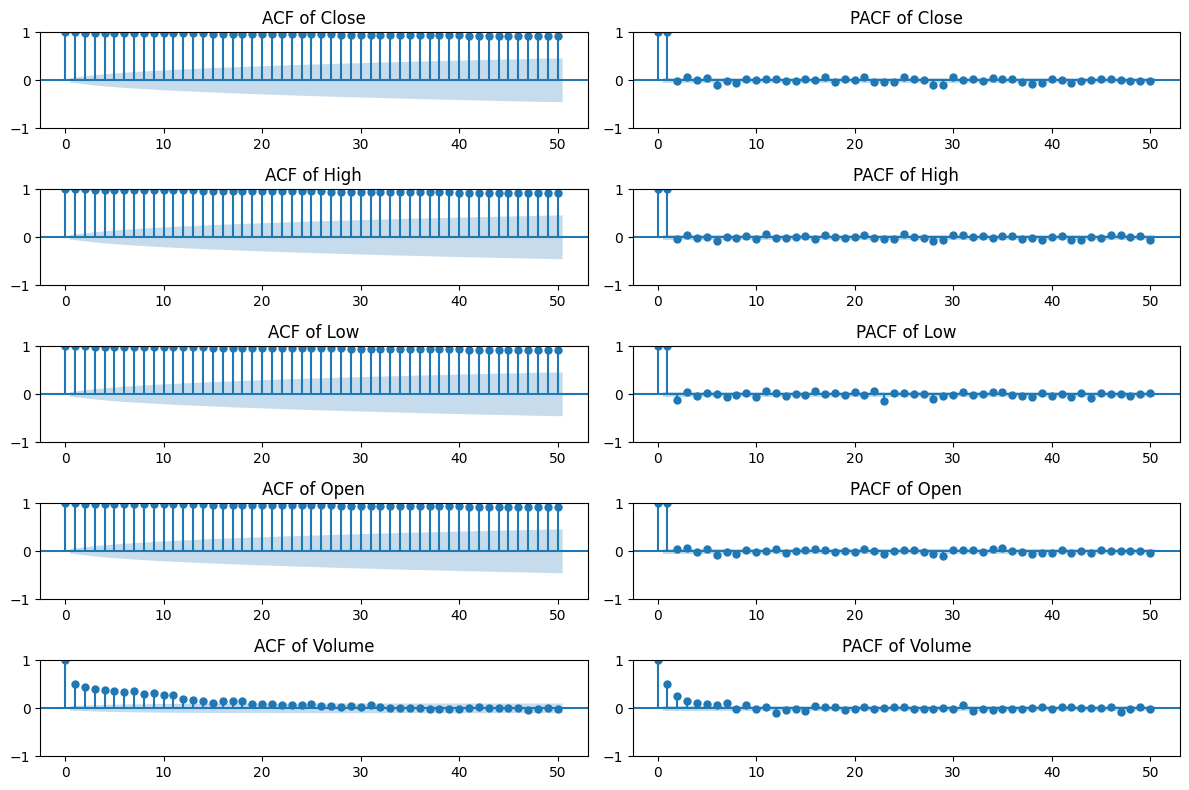

In [21]:
fig, axes = plt.subplots(len(cols), 2, figsize=(12, 8))

for i, col in enumerate(cols):  
    data = stock_data[col].dropna()
    plot_acf(data, lags=50, ax=axes[i, 0], title=f'ACF of {col}')  
    plot_pacf(data, lags=50, ax=axes[i, 1], title=f'PACF of {col}')  

plt.tight_layout()  
plt.show()

Hasil grafik ACF dan PACF untuk variabel:

- Close, High, Low, Open: ACF semuanya menunjukkan pola yang sangat lambat menurun (slow decay) dengan nilai tinggi dan mendekati 1 hingga lag yang jauh. Ini mengindikasikan bahwa data series ini bersifat non-stasioner, atau memiliki tren jangka panjang. Nilai saat ini sangat berkorelasi dengan nilai di masa lalu dalam jangka waktu yang panjang. PACF menunjukkan spike signifikan hanya pada lag 1 & lag 2, kemudian langsung turun mendekati nol untuk lag berikutnya. Ini biasanya mengindikasikan pola AR(1), yaitu data dipengaruhi dominan oleh nilai sebelumnya satu periode.
- Volume: ACF Volume menurun secara bertahap namun lebih cepat dibandingkan dengan harga (Close, High, Low, Open), menunjukkan data ini memiliki ketergantungan waktu yang lebih lemah dan kemungkinan lebih mendekati stasioner. PACF Volume menunjukkan nilai terbesar di lag 1 dan beberapa lag awal signifikan, kemudian cukup cepat menurun mendekati nol. Hal ini mengindikasikan pola AR atau ARMA dengan orde rendah. Volume bisa jadi lebih mudah distasionerkan

## Data Preparation

Beberapa hal akan dilakukan pada bagian ini, seperti:
- Standarisasi data
- Set kolom 'Date' sebagai index
- Proses train-test split

In [23]:
scaler = StandardScaler()
stock_data[cols] = scaler.fit_transform(stock_data[cols])
stock_data.describe().round(1)

,Date,Close,High,Low,Open,Volume
count,1679,1679.0,1679.0,1679.0,1679.0,1679.0
mean,2021-10-11 06:02:47.242406144,0.0,-0.0,0.0,0.0,0.0
min,2018-06-01 00:00:00,-1.5,-1.5,-1.5,-1.5,-0.6
25%,2020-01-15 12:00:00,-1.0,-1.0,-1.0,-1.0,-0.4
50%,2021-10-07 00:00:00,0.0,0.0,0.0,0.0,-0.3
75%,2023-06-30 00:00:00,0.6,0.6,0.7,0.6,0.0
max,2025-03-27 00:00:00,2.1,2.1,2.1,2.1,14.5
std,NaN,1.0,1.0,1.0,1.0,1.0


Metode Standarisasi digunakan untuk mengubah skala data dikarenakan bentuk distribusinya tidak ada yang normal/bell-curved

In [24]:
stock_data.set_index('Date', inplace=True)

##### Data Preparation untuk pemodelan dengan menggunakan ARIMA

In [25]:
def check_stationarity(series, name=''):
    result = adfuller(series.dropna())
    print(f'ADF Statistic {name}: {result[0]}')
    print(f'p-value: {result[1]}')

for col in cols:
    check_stationarity(stock_data[col], name=col)

ADF Statistic Close: -1.2891901383709483
p-value: 0.634103213468296
ADF Statistic High: -1.2730169958768143
p-value: 0.6414249053707295
ADF Statistic Low: -1.2849431459937775
p-value: 0.6360323826488619
ADF Statistic Open: -1.2775821430410796
p-value: 0.6393650943181299
ADF Statistic Volume: -7.102931179384038
p-value: 4.123193524387941e-10


Hasil dengan ADF test menyatakan bahwa semua kolom data perlu didifferencing karena nilai p-value > 0.05. Ini dilakukan untuk menjadikan data stasioner (karakteristik statistik tidak berubah sepanjang waktu) agar bisa pemodelan dengan pendekatan time-series (ARIMA)

In [26]:
diff_data = stock_data.diff().dropna()

Splliting data untuk pemodelan dengan ARIMA

In [27]:
split_index = int(len(diff_data) * 0.7)
train = diff_data.iloc[:split_index]
valid = diff_data.iloc[split_index:]

In [28]:
print(f"Jumlah data train: {train.shape}")
print(f"Jumlah data valid: {valid.shape}")

Jumlah data train: (1174, 5)
Jumlah data valid: (504, 5)


#### Data Preparation untuk pemodelan dengan Deep Learning

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
prices = stock_data['Close'].values

In [ ]:
SPLIT_TIME = int(len(prices) * 0.7)
train_price = prices[:SPLIT_TIME]
valid_price = prices[SPLIT_TIME:]

In [ ]:
print(f"Jumlah data train: {train_price.shape}")
print(f"Jumlah data valid: {valid_price.shape}")

Jumlah data train: (1175,)
Jumlah data valid: (504,)


In [ ]:
BATCH_SIZE = 4
WINDOW_SIZE = 2
SHUFFLE_BUFFER = 1000

train_set = windowed_dataset(series=train_price, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER)
valid_set = windowed_dataset(series=valid_price, window_size=WINDOW_SIZE, batch_size=BATCH_SIZE, shuffle_buffer=SHUFFLE_BUFFER)

## Modelling Process

Dalam pemodelan ini saya membandingkan 3 jenis model, yaitu ARIMA, LSTM, dan GRU

#### ARIMA

In [29]:
model = ARIMA(train['Close'], order=(1,1,2))
result = model.fit()
print('Fitted ARIMA model for Close Prices')
print(result.summary())

c:\Users\hardi\anaconda3\envs\py310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hardi\anaconda3\envs\py310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\hardi\anaconda3\envs\py310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Fitted ARIMA model for Close Prices
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                 1174
Model:                 ARIMA(1, 1, 2)   Log Likelihood                1947.486
Date:                Mon, 21 Apr 2025   AIC                          -3886.973
Time:                        15:14:22   BIC                          -3866.703
Sample:                             0   HQIC                         -3879.329
                               - 1174                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.9048      0.062    -14.643      0.000      -1.026      -0.784
ma.L1         -0.0665      0.055     -1.213      0.225      -0.174       0.041
ma.L2         -0

In [30]:
forecast_horizon = len(valid)

forecast = result.get_forecast(steps=forecast_horizon)
forecast_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

forecast_df = pd.DataFrame({'forecast': forecast_mean})

c:\Users\hardi\anaconda3\envs\py310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


#### LSTM

In [ ]:
tf.random.set_seed(42)

early_stop_callback = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath='model_best.h5', monitor='val_loss', verbose=1, save_best_only=True)
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, verbose=1)

callbacks = [early_stop_callback, checkpoint, reduce_lr_callback]

In [ ]:
model_lstm = Sequential([
    LSTM(128, input_shape=(WINDOW_SIZE, 1),return_sequences=True, activation='tanh'),
    LSTM(256, return_sequences=True, activation='tanh'),
    BatchNormalization(),
    LSTM(128, return_sequences=True, activation='tanh'),
    LSTM(64, return_sequences=True, activation='tanh'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model_lstm.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

In [ ]:
hist_lstm = model_lstm.fit(train_set, validation_data=valid_set, epochs=50, callbacks=callbacks)

Epoch 1/50
    291/Unknown - 10s 15ms/step - loss: 0.1825 - mae: 0.1825 - mse: 0.0737
Epoch 1: val_loss improved from inf to 1.27567, saving model to model_best.h5
294/294 [==============================] - 13s 24ms/step - loss: 0.1821 - mae: 0.1821 - mse: 0.0734 - val_loss: 1.2757 - val_mae: 1.2757 - val_mse: 1.7983 - lr: 0.0010
Epoch 2/50
294/294 [==============================] - ETA: 0s - loss: 0.1031 - mae: 0.1031 - mse: 0.0182
Epoch 2: val_loss improved from 1.27567 to 0.98879, saving model to model_best.h5
294/294 [==============================] - 5s 18ms/step - loss: 0.1031 - mae: 0.1031 - mse: 0.0182 - val_loss: 0.9888 - val_mae: 0.9888 - val_mse: 1.1047 - lr: 0.0010
Epoch 3/50
291/294 [============================>.] - ETA: 0s - loss: 0.0910 - mae: 0.0910 - mse: 0.0141
Epoch 3: val_loss improved from 0.98879 to 0.70383, saving model to model_best.h5
294/294 [==============================] - 5s 19ms/step - loss: 0.0910 - mae: 0.0910 - mse: 0.0141 - val_loss: 0.7038 - val_mae

#### GRU

In [ ]:
model_gru = Sequential([
    GRU(128, input_shape=(WINDOW_SIZE, 1),return_sequences=True, activation='tanh'),
    GRU(256, return_sequences=True, activation='tanh'),
    BatchNormalization(),
    GRU(128, return_sequences=True, activation='tanh'),
    GRU(64, return_sequences=True, activation='tanh'),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

optimizer = Adam(learning_rate=0.001)
model_gru.compile(optimizer=optimizer, loss='mae', metrics=['mae', 'mse'])

In [ ]:
hist_gru = model_gru.fit(train_set, validation_data=valid_set, epochs=50, callbacks=callbacks)

Epoch 1/50
    293/Unknown - 12s 18ms/step - loss: 0.1919 - mae: 0.1919 - mse: 0.0764
Epoch 1: val_loss did not improve from 0.51269
294/294 [==============================] - 15s 27ms/step - loss: 0.1919 - mae: 0.1919 - mse: 0.0764 - val_loss: 1.3301 - val_mae: 1.3301 - val_mse: 1.9640 - lr: 0.0010
Epoch 2/50
294/294 [==============================] - ETA: 0s - loss: 0.1168 - mae: 0.1168 - mse: 0.0229
Epoch 2: val_loss did not improve from 0.51269
294/294 [==============================] - 7s 22ms/step - loss: 0.1168 - mae: 0.1168 - mse: 0.0229 - val_loss: 0.7942 - val_mae: 0.7942 - val_mse: 0.7379 - lr: 0.0010
Epoch 3/50
294/294 [==============================] - ETA: 0s - loss: 0.1051 - mae: 0.1051 - mse: 0.0184
Epoch 3: val_loss did not improve from 0.51269
294/294 [==============================] - 6s 20ms/step - loss: 0.1051 - mae: 0.1051 - mse: 0.0184 - val_loss: 0.7784 - val_mae: 0.7784 - val_mse: 0.7498 - lr: 0.0010
Epoch 4/50
293/294 [============================>.] - ETA: 0s

## Evaluation

##### Evaluasi pada hasil Model ARIMA

MAE for Close Price: 0.0527
MSE for Close Price: 0.0053


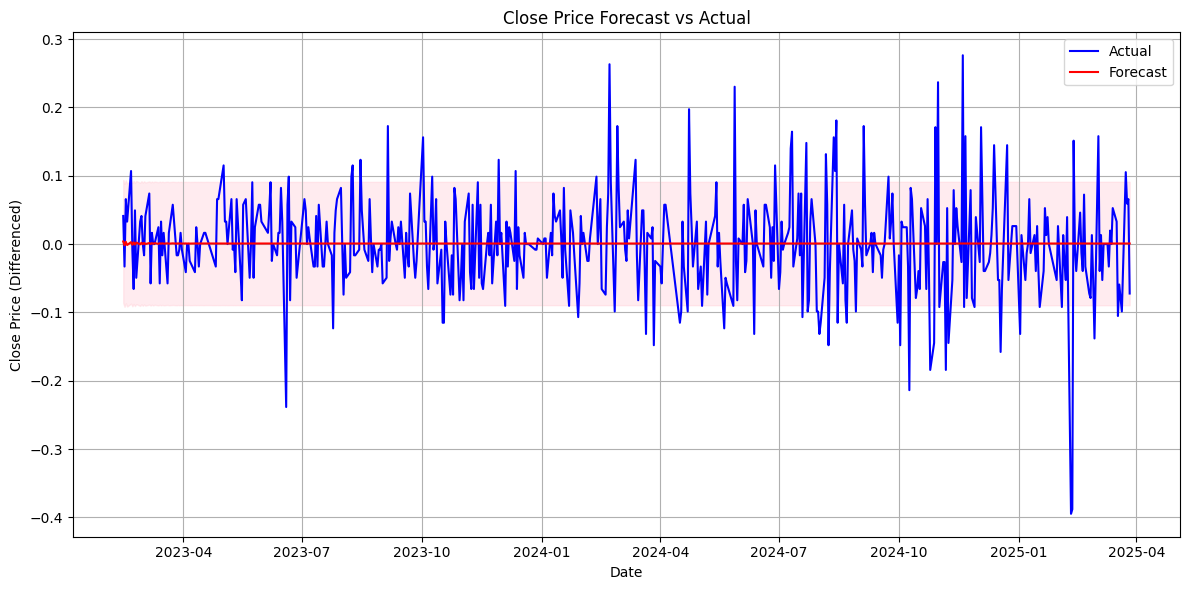

In [31]:
mse = mean_squared_error(valid['Close'], forecast_mean)
mae = mean_absolute_error(valid['Close'], forecast_mean)
print(f'MAE for Close Price: {mae:.4f}')
print(f'MSE for Close Price: {mse:.4f}')

plt.figure(figsize=(12, 6))
plt.plot(valid.index, valid['Close'], label='Actual', color='blue')
plt.plot(valid.index, forecast_mean, label='Forecast', color='red')
plt.fill_between(valid.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Close Price Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Close Price (Differenced)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Pemaparan terkait Evaluasi Metrik dari hasil pemodelan dengan ARIMA

- MAE (Mean Absolute Error) sebesar 0.0527 menunjukkan bahwa secara rata-rata, prediksi meleset sekitar 0.0536 unit dari nilai aktual.
- MSE (Mean Squared Error) sebesar 0.0053 relatif kecil, namun ini disebabkan oleh prediksi yang konsisten di sekitar nilai rata-rata, bukan karena model berhasil menangkap pola volatilitas.
- Model ARIMA ini cenderung memprediksi nilai mendekati rata-rata (mean reverting) dan tidak menangkap volatilitas harga saham.

##### Evaluasi pada Model LSTM

In [ ]:
def plot_metrics(history_model):
    available_keys = history_model.history.keys()
    print("Available metrics:", available_keys)

    loss = history_model.history.get('loss')
    val_loss = history_model.history.get('val_loss')
    mae = history_model.history.get('mae')
    val_mae = history_model.history.get('val_mae')
    mse = history_model.history.get('mse')
    val_mse = history_model.history.get('val_mse')

    epochs_range = range(1, len(loss) + 1)

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title('Loss')
    plt.legend()

    if mae and val_mae:
        plt.subplot(1, 3, 2)
        plt.plot(epochs_range, mae, label='Train MAE')
        plt.plot(epochs_range, val_mae, label='Val MAE')
        plt.title('Mean Absolute Error')
        plt.legend()

    if mse and val_mse:
        plt.subplot(1, 3, 3)
        plt.plot(epochs_range, mse, label='Train MSE')
        plt.plot(epochs_range, val_mse, label='Val MSE')
        plt.title('Mean Squared Error')
        plt.legend()

    plt.tight_layout()
    plt.show()

Available metrics: dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse', 'lr'])


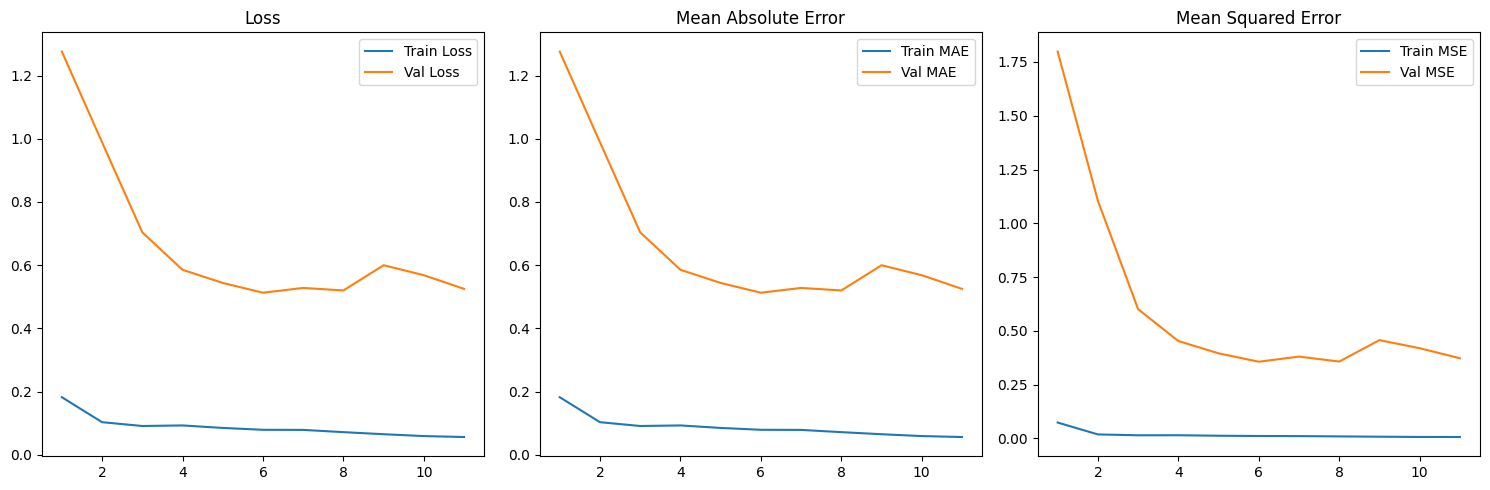

In [ ]:
plot_metrics(hist_lstm)

Hasil dari pemodelan menggunakan LSTM menunjukkan progress yang baik pada train set, namun pada validation set performanya masih cenderung kurang baik.

In [ ]:
X_valid = []
y_valid = []

for x_batch, y_batch in valid_set:
    X_valid.append(x_batch.numpy())
    y_valid.append(y_batch.numpy())

X_valid = np.concatenate(X_valid, axis=0)
y_valid = np.concatenate(y_valid, axis=0)

In [ ]:
def plot_forecasting(model, model_name):
    y_pred = model.predict(X_valid)
    
    if len(y_pred.shape) == 3:
        y_pred = y_pred[:, -1, 0]
    if len(y_valid.shape) == 3:
        y_valid_plot = y_valid[:, -1, 0]
    else:
        y_valid_plot = y_valid
    
    mse = mean_squared_error(y_valid_plot, y_pred)
    mae = mean_absolute_error(y_valid_plot, y_pred)
    print(f'MAE for {model_name}: {mae:.4f}')
    print(f'MSE for {model_name}: {mse:.4f}')

    plt.figure(figsize=(12, 6))
    plt.plot(y_valid_plot, label='Actual', color='blue')
    plt.plot(y_pred, label='Forecast', color='red')
    plt.title(f'{model_name} Forecast vs Actual')
    plt.xlabel('Time Step')
    plt.ylabel('Close Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

16/16 [==============================] - 0s 7ms/step
MAE for LSTM: 0.5035
MSE for LSTM: 0.3469


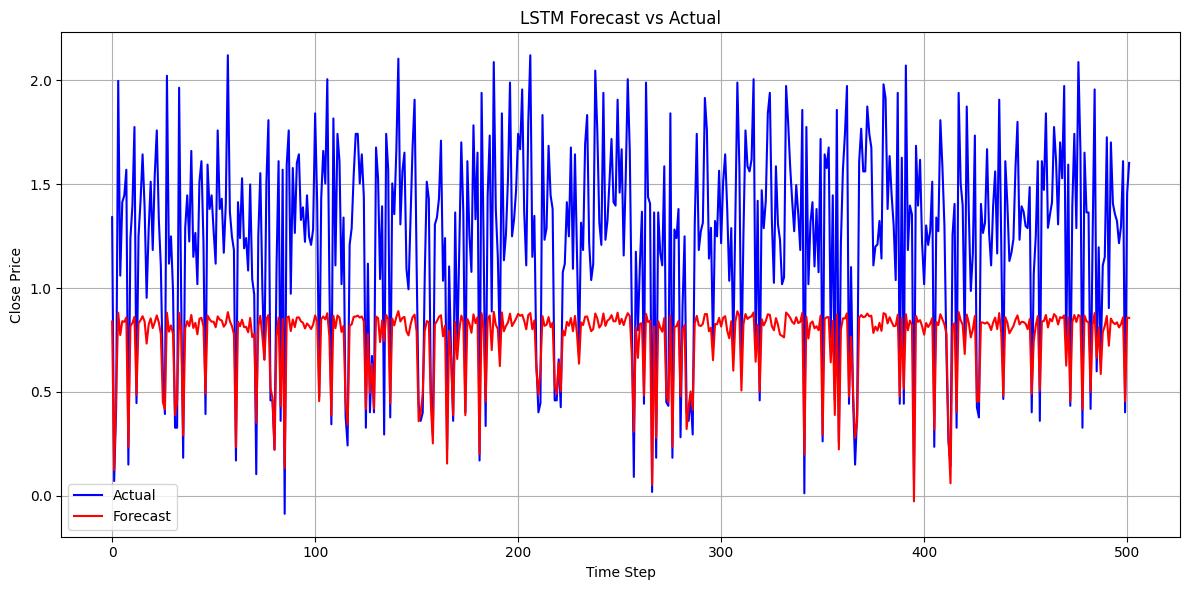

In [ ]:
plot_forecasting(model_lstm, "LSTM")

Pemaparan terkait Evaluasi Metrik dari menggunakan model LSTM

- MAE sebesar 0.5035 menunjukkan rata-rata kesalahan prediksi cukup signifikan.
- MSE sebesar 0.3469 lebih tinggi dari model ARIMA sebelumnya (karena penggunaan data untuk ARIMA melewati proses difference), mengindikasikan bahwa meskipun LSTM berusaha menangkap volatilitas, akurasi prediksinya masih kurang memuaskan.
- Model LSTM mampu untuk menangkap beberapa pola penurunan tajam pada data (downspikes), tetapi gagal memprediksi dengan tepat pola kenaikan yang dominan pada data aktual.

#### Evaluasi pada Model GRU

Available metrics: dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse', 'lr'])


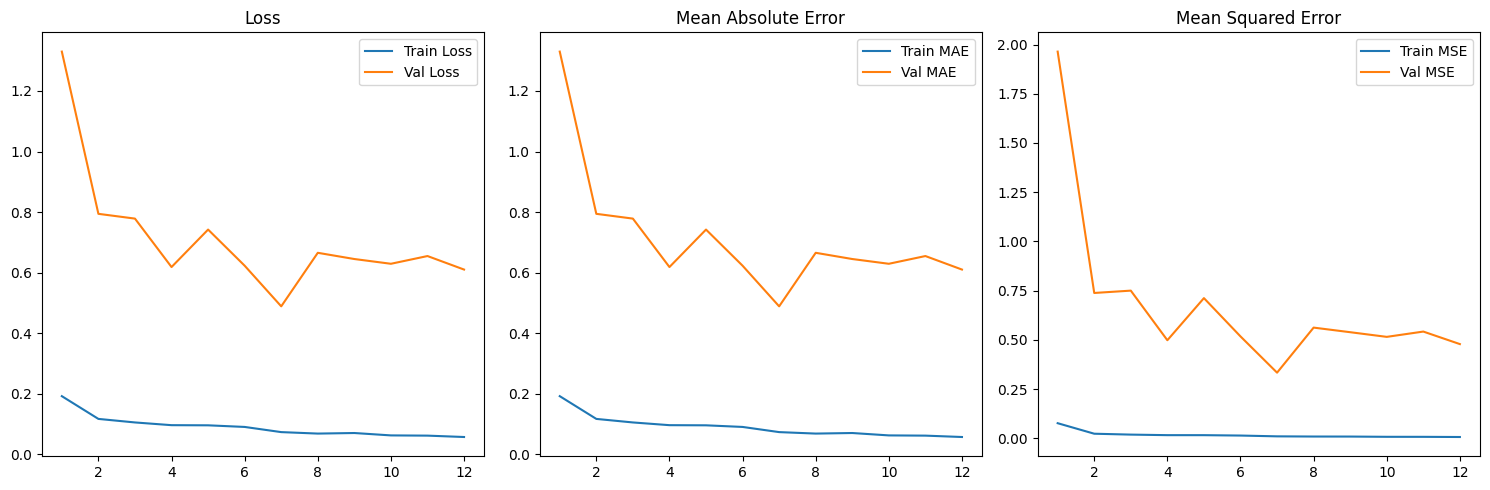

In [ ]:
plot_metrics(hist_gru)

Hasil dari pemodelan menggunakan GRU menunjukkan progress yang baik pada train set, namun pada validation set performanya masih cenderung kurang baik meskipun hasilnya sedikit lebih baik dari LSTM.

16/16 [==============================] - 0s 15ms/step
MAE for GRU: 0.4531
MSE for GRU: 0.2909


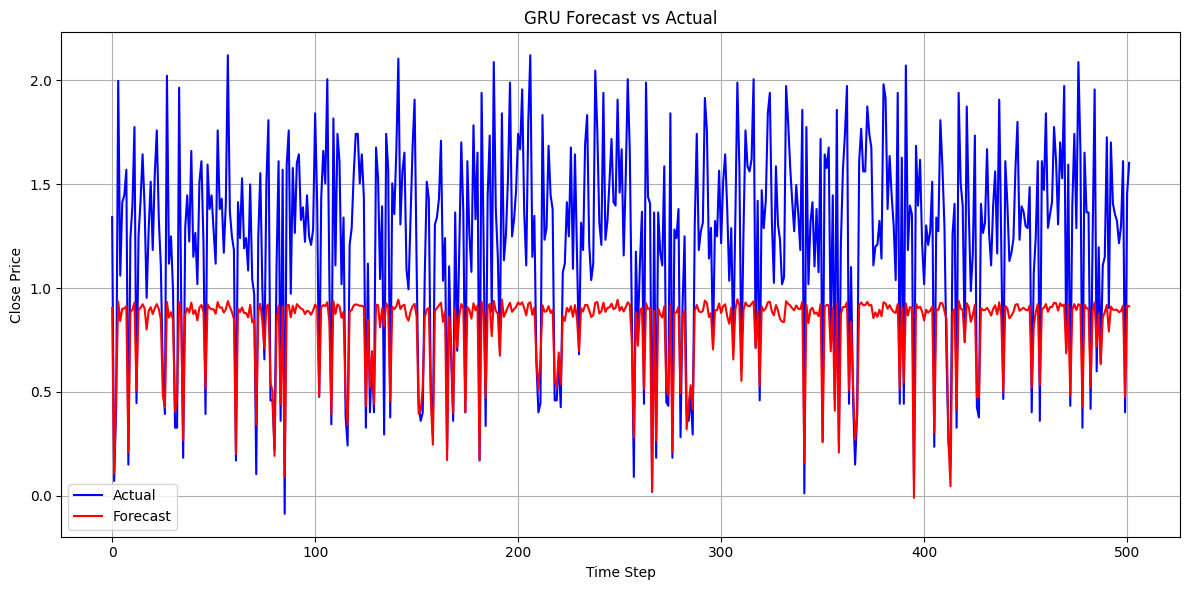

In [ ]:
plot_forecasting(model_gru, "GRU")

Pemaparan terkait Evaluasi Metrik dari menggunakan model GRU

- MAE sebesar 0.4531 menunjukkan rata-rata kesalahan prediksi masih cukup signifikan, namun hasilnya lebih baik dari LSTM.
- MSE sebesar 0.2909 lebih tinggi dari model LSTM, namun tetap akurasi prediksinya masih kurang memuaskan.
- Model GRU mampu untuk menangkap beberapa pola penurunan tajam pada data (downspikes), tetapi gagal memprediksi dengan tepat pola kenaikan yang dominan pada data aktual.

#### Kesimpulan Akhir dari Hasil Pemodelan

- Hasil pemodelan yang terbaik dari 3 metode yang dicoba (ARIMA, LSTM, dan GRU) diperoleh dengan menggunakan model GRU.
- Hasil forecasting menggunakan ARIMA kurang bisa menangkap volatilitas pada data dengan baik
- Hasil forecasting dengan LSTM & GRU agak sedikit mampu menangkap pola penurunan tajam pada data, namun gagal memprediksi dengan tepat pola kenaikan dominan 